# Practical Machine Learning for Physicists
## Week 6 Exercise 
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Import tqdm for progress bar
from tqdm import tqdm

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



In [2]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

In [17]:
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]
tmax, dt = 150, 0.1
t = np.arange(0, tmax+dt, dt)

In [18]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x_1, y_1, x_2, y_2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 1501)


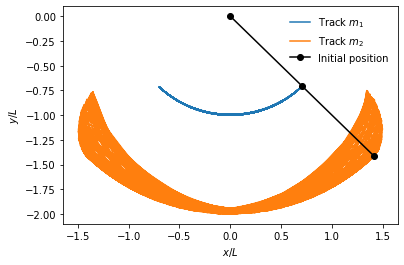

In [19]:
fig,ax=plt.subplots()
ax.plot(x_1, y_1, label=r"Track $m_1$")
ax.plot(x_2, y_2, label=r"Track $m_2$")
ax.plot([0, x_1[0], x_2[0]], [0, y_1[0], y_2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



# Task 1 - predicting future positions

In [8]:
#This function splits up a 2-d array z into a series of overlapping windows
#The return is a tuple of the array of input windows and target (output) windows
def shapeArray(z,windowsize,offset):
    Input= np.array([z[i : i + windowsize , :] for i in range(timesteps-(windowsize+offset))])
    Output= np.array([z[i +offset : i+ windowsize+offset,:] for i in range(timesteps-(windowsize+offset))])
    return (Input,Output)

windowsize=80 #Number of samples in each training batch
offset=20 #How many samples into the future to predict

In [9]:
#Define and compile model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(64,input_shape=(windowsize,4),return_sequences=True)) # LSTM layer with 64 neurons
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(32,activation="linear"))
model.add(keras.layers.Dense(4,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 80, 64)            17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 31,268
Trainable params: 31,268
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 150/150 [02:00<00:00,  1.24it/s]


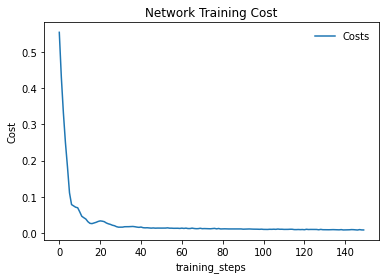

In [13]:
training_steps=150
cost=np.zeros(training_steps)

for i in tqdm(range(training_steps)):
 
  theta_1_start=np.random.uniform(low=((np.pi/4)),high=((np.pi/4)))
  theta_2_start=np.random.uniform(low=((np.pi/4)-0.01),high=((np.pi/4)+0.01))

  z0=[theta_1_start,0,theta_2_start,0]
  tmax, dt = 100, 0.1
  t = np.arange(0, tmax+dt, dt)
  
  # Solve initial value problem
  ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
  z=ret.y

  # Extract result
  theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
  x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)   
  
  # Make training data

  x1=np.reshape(x1,(np.shape(x1)[0],1))
  x2=np.reshape(x2,(np.shape(x2)[0],1))
  y1=np.reshape(y1,(np.shape(y1)[0],1))
  y2=np.reshape(y2,(np.shape(y2)[0],1))

  positions=np.concatenate((x1,x2,y1,y2),axis=1)

  # defining the number of timesteps (as required by the shapeArray function, which we will call next)
  timesteps=int(tmax//dt)

  # Making input and output arrays:
  input,output=shapeArray(positions,windowsize,offset)
  output=output[:,-1,:]
  
  # training the model
  cost[i]=model.train_on_batch(input,output)

#Plot costs vs steps
fig,ax=plt.subplots()
ax.plot(np.arange(training_steps),cost,label=r"Costs")
ax.set_xlabel("training_steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

In [21]:
# Making testing data

  # taking x_1,x_2,y_1,y_2, as defined above the tasks (ie using the initial conditions given in the question)

x_1=np.reshape(x_1,(np.shape(x_1)[0],1))
x_2=np.reshape(x_2,(np.shape(x_2)[0],1))
y_1=np.reshape(y_1,(np.shape(y_1)[0],1))
y_2=np.reshape(y_2,(np.shape(y_2)[0],1))

positions=np.concatenate((x_1,x_2,y_1,y_2),axis=1)

timesteps=int(tmax//dt)

# Making testing input and output arrays:
test_input,test_output=shapeArray(positions,windowsize,offset)
test_output=test_output[:,-1,:]

In [22]:
# TESTING

prediction = model.predict_on_batch(test_input)
mean_squared_test_error = np.mean((prediction-test_output)**2)

print('\nMean squared test error: ', mean_squared_test_error)


Mean squared test error:  0.008993752981785414


Discussion: this low error shows a good prediction ability of the network.

# Task 2 - how stable is the network to variation in initial conditions?


mean squared test error=  0.5764059255431325


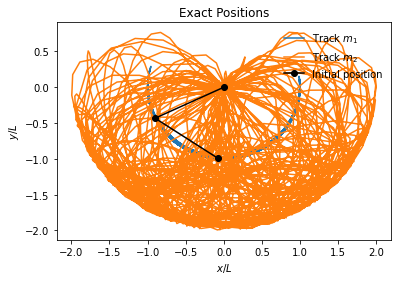

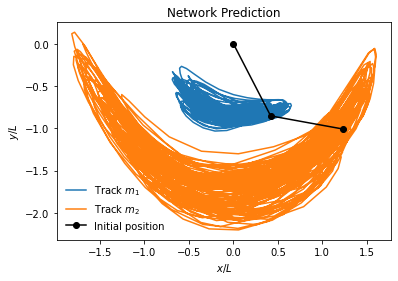

In [27]:
# solving initial value problem with different (arbitrarily chosen) initial conditions:
ret = solve_ivp(rhs, (0,tmax), [-1.4,0,1,0], t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)   

#plotting result from solver
fig,ax=plt.subplots()
ax.plot(x1[20:], y1[20:], label=r"Track $m_1$")
ax.plot(x2[20:], y2[20:], label=r"Track $m_2$")
ax.plot([0, x1[20], x2[20]], [0, y1[20], y2[20]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
plt.title('Exact Positions')
ax.legend()

# Make prediction input data for lstm netwrok
x1=np.reshape(x1,(np.shape(x1)[0],1))
x2=np.reshape(x2,(np.shape(x2)[0],1))
y1=np.reshape(y1,(np.shape(y1)[0],1))
y2=np.reshape(y2,(np.shape(y2)[0],1))

positions=np.concatenate((x1,x2,y1,y2),axis=1)

input,output=shapeArray(positions,windowsize,offset)
output=output[:,-1,:]

# Getting model prediction
prediction = model.predict_on_batch(input)

model_x1=prediction[:,0]
model_x2=prediction[:,1]
model_y1=prediction[:,2]
model_y2=prediction[:,3]

#plotting result from model
fig,ax=plt.subplots()
ax.plot(model_x1, model_y1, label=r"Track $m_1$")
ax.plot(model_x2, model_y2, label=r"Track $m_2$")
ax.plot([0, model_x1[0], model_x2[0]], [0, model_y1[0], model_y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
plt.title('Network Prediction')
ax.legend()

print('\nmean squared test error= ', np.mean((prediction-output)**2))

Discussion: the network clearly has significant trouble dealing with completely different initial conditions. This is because the model was only trained within an extremely small range of starting conditions, centered on the starting conditions given in the question. It has never seen time series and corresponding future positions that arise from different initial conditions, so the weights of the network aren't optimised for predicting them. Hence the significantly higher testing error.  

# Task 3 - how far into the future can the network predict?

100%|██████████| 80/80 [01:06<00:00,  1.21it/s]


100%|██████████| 80/80 [01:07<00:00,  1.19it/s]


100%|██████████| 80/80 [01:06<00:00,  1.20it/s]


100%|██████████| 80/80 [01:05<00:00,  1.22it/s]


100%|██████████| 80/80 [01:06<00:00,  1.20it/s]


100%|██████████| 80/80 [01:06<00:00,  1.21it/s]


100%|██████████| 80/80 [01:10<00:00,  1.14it/s]


100%|██████████| 80/80 [01:05<00:00,  1.22it/s]


100%|██████████| 80/80 [01:03<00:00,  1.26it/s]


100%|██████████| 80/80 [01:03<00:00,  1.25it/s]


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


100%|██████████| 80/80 [01:05<00:00,  1.22it/s]


100%|██████████| 80/80 [01:06<00:00,  1.20it/s]


100%|██████████| 80/80 [01:06<00:00,  1.20it/s]


100%|██████████| 80/80 [01:05<00:00,  1.22it/s]


100%|██████████| 80/80 [01:04<00:00,  1.24it/s]


100%|██████████| 80/80 [01:06<00:00,  1.20it/s]


100%|██████████| 80/80 [01:06<00:00,  1.20it/s]


ValueError: ignored

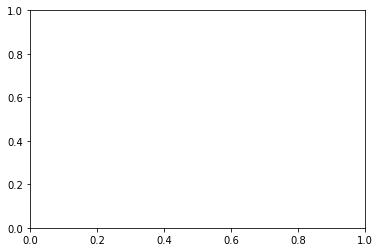

In [40]:
training_steps=80

num_offsets=21
offsets=np.linspace(20,80,num_offsets)  # array containing different depths into the future we want to predict for

# initialising the mean_squared_test_error array:
mean_squared_test_error=np.zeros(num_offsets)

for j in range(num_offsets):
  
  #Define and compile model
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(64,input_shape=(windowsize,4),return_sequences=True)) # LSTM layer with 64 neurons
  model.add(keras.layers.LSTM(32))
  model.add(keras.layers.Dense(32,activation="linear"))
  model.add(keras.layers.Dense(4,activation="linear"))
  model.compile(loss='mean_squared_error',optimizer='adam')

  # initialising the cost array
  cost=np.zeros(training_steps)  
  
  for i in tqdm(range(training_steps)):
 
    theta_1_start=np.random.uniform(low=((np.pi/4)),high=((np.pi/4)))
    theta_2_start=np.random.uniform(low=((np.pi/4)-0.01),high=((np.pi/4)+0.01))

    z0=[theta_1_start,0,theta_2_start,0]
    tmax, dt = 100, 0.1
    t = np.arange(0, tmax+dt, dt)
    
    # Solve initial value problem
    ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y

    # Extract result
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)   
    
    # Make training data
    x1=np.reshape(x1,(np.shape(x1)[0],1))
    x2=np.reshape(x2,(np.shape(x2)[0],1))
    y1=np.reshape(y1,(np.shape(y1)[0],1))
    y2=np.reshape(y2,(np.shape(y2)[0],1))

    positions=np.concatenate((x1,x2,y1,y2),axis=1)

    # defining the number of timesteps (as required by the shapeArray function, which we will call next)
    timesteps=int(tmax//dt)

    # Making input and output arrays:
    input,output=shapeArray(positions,windowsize,int(offsets[j]))
    output=output[:,-1,:]
    
    # Training
    cost[i]=model.train_on_batch(input,output)

  # Making testing input and output arrays:
  positions=np.concatenate((x_1,x_2,y_1,y_2),axis=1)    # x_1 etc as defined in task 1
  timesteps=int(tmax//dt)
  test_input,test_output=shapeArray(positions,windowsize,int(offsets[j]))
  test_output=test_output[:,-1,:]

  # TESTING
  prediction = model.predict_on_batch(test_input)
  mean_squared_test_error[j] = np.mean((prediction-test_output)**2)

Text(0.5, 1.0, 'Error vs. depth of prediction into future')

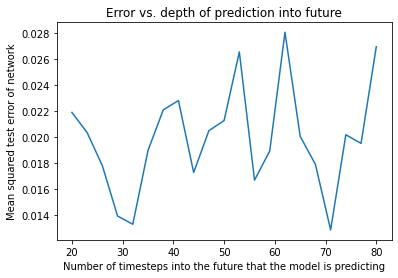

In [43]:
#Plot costs vs steps
fig,ax=plt.subplots()
ax.plot(offsets,mean_squared_test_error)
ax.set_xlabel("Number of timesteps into the future that the model is predicting")
ax.set_ylabel("Mean squared test error of network")
ax.set_title("Error vs. depth of prediction into future")

Discussion: although the fluctuation of the errors vs. prediction depth is large in relative terms, it is not significant in absolute terms. This is because all the errors are within the range 0.014 to 0.028, which is a very low error. This suggests that the netowrk's effectiveness at predicting the future positions does not change appreciably between predicting 20 and 80 timesteps into the future. 

# Task 4 - repeating tasks 1-3 for initial initial conditions: $z_0=[\pi/2,0,\pi/2,0]$

  0%|          | 0/150 [00:00<?, ?it/s]

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 80, 64)            17664     
_________________________________________________________________
lstm_57 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_56 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 132       
Total params: 31,268
Trainable params: 31,268
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 150/150 [02:15<00:00,  1.11it/s]



Mean squared test error:  0.4286833235554884


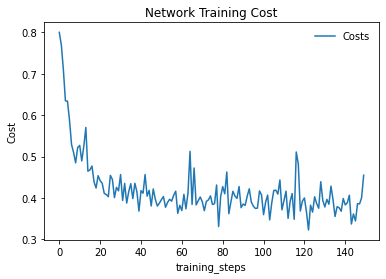

In [44]:
# -- PREDICTING FUTURE POSITIONS -- 

#Define and compile model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(64,input_shape=(windowsize,4),return_sequences=True)) # LSTM layer with 64 neurons
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(32,activation="linear"))
model.add(keras.layers.Dense(4,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')    
model.summary()

training_steps=150
cost=np.zeros(training_steps)

for i in tqdm(range(training_steps)):
 
  theta_1_start=np.random.uniform(low=((np.pi/2)),high=((np.pi/2)))
  theta_2_start=np.random.uniform(low=((np.pi/2)-0.01),high=((np.pi/2)+0.01))

  z0=[theta_1_start,0,theta_2_start,0]
  tmax, dt = 100, 0.1
  t = np.arange(0, tmax+dt, dt)
  
  # Solve initial value problem
  ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
  z=ret.y

  # Extract result
  theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
  x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)   
  
  # Make training data

  x1=np.reshape(x1,(np.shape(x1)[0],1))
  x2=np.reshape(x2,(np.shape(x2)[0],1))
  y1=np.reshape(y1,(np.shape(y1)[0],1))
  y2=np.reshape(y2,(np.shape(y2)[0],1))

  positions=np.concatenate((x1,x2,y1,y2),axis=1)

  # defining the number of timesteps (as required by the shapeArray function, which we will call next)
  timesteps=int(tmax//dt)

  # Making input and output arrays:
  input,output=shapeArray(positions,windowsize,offset)
  output=output[:,-1,:]
  
  # training the model
  cost[i]=model.train_on_batch(input,output)

#Plot costs vs steps
fig,ax=plt.subplots()
ax.plot(np.arange(training_steps),cost,label=r"Costs")
ax.set_xlabel("training_steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

# Making testing data

z0=[np.pi/2,0,np.pi/2,0]
tmax, dt = 100, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2) 


x1=np.reshape(x1,(np.shape(x1)[0],1))
x2=np.reshape(x2,(np.shape(x2)[0],1))
y1=np.reshape(y1,(np.shape(y1)[0],1))
y2=np.reshape(y2,(np.shape(y2)[0],1))

positions=np.concatenate((x1,x2,y1,y2),axis=1)

timesteps=int(tmax//dt)

# Making testing input and output arrays:
test_input,test_output=shapeArray(positions,windowsize,offset)
test_output=test_output[:,-1,:]

# TESTING

prediction = model.predict_on_batch(test_input)
mean_squared_test_error = np.mean((prediction-test_output)**2)

print('\nMean squared test error: ', mean_squared_test_error)

Discussion: here we can see that for the initial conditions of $z_0=[\pi/2,0,\pi/2,0]$ the mean squared test error is much higher - 0.429 compared to 0.009 for  $z_0=[\pi/4,0,\pi/4,0]$. This is because the system is much more chaotic. Perhaps more lstm layers with more neurons and a larger number of training steps would improve the performance.


mean squared test error=  0.34395292697205454


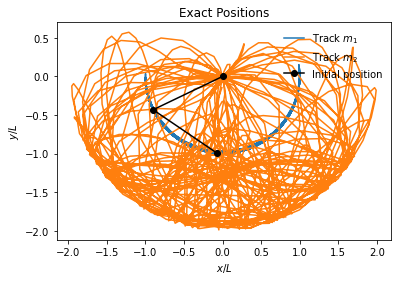

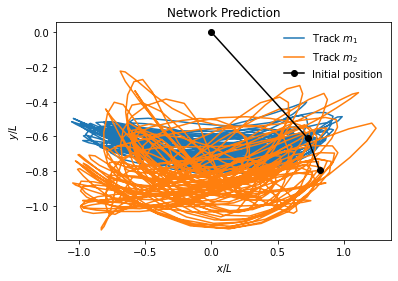

In [45]:
# -- HOW STABLE IS THE NETOWRK TO VARIATION IN INITIAL CONDITIONS?

# solving initial value problem with different (arbitrarily chosen) initial conditions:
ret = solve_ivp(rhs, (0,tmax), [-1.4,0,1,0], t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)   

#plotting result from solver
fig,ax=plt.subplots()
ax.plot(x1[20:], y1[20:], label=r"Track $m_1$")
ax.plot(x2[20:], y2[20:], label=r"Track $m_2$")
ax.plot([0, x1[20], x2[20]], [0, y1[20], y2[20]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
plt.title('Exact Positions')
ax.legend()

# Make prediction input data for lstm netwrok
x1=np.reshape(x1,(np.shape(x1)[0],1))
x2=np.reshape(x2,(np.shape(x2)[0],1))
y1=np.reshape(y1,(np.shape(y1)[0],1))
y2=np.reshape(y2,(np.shape(y2)[0],1))

positions=np.concatenate((x1,x2,y1,y2),axis=1)

input,output=shapeArray(positions,windowsize,offset)
output=output[:,-1,:]

# Getting model prediction
prediction = model.predict_on_batch(input)

model_x1=prediction[:,0]
model_x2=prediction[:,1]
model_y1=prediction[:,2]
model_y2=prediction[:,3]

#plotting result from model
fig,ax=plt.subplots()
ax.plot(model_x1, model_y1, label=r"Track $m_1$")
ax.plot(model_x2, model_y2, label=r"Track $m_2$")
ax.plot([0, model_x1[0], model_x2[0]], [0, model_y1[0], model_y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
plt.title('Network Prediction')
ax.legend()

print('\nmean squared test error= ', np.mean((prediction-output)**2))

Discussion: here we can see that, since the network was trained on a more chaotic system, it performs better than the first network when the initial conditions are changed to something that also gives a chaotic path. This is evidenced by the lower mean squared testing error for this network compared to the first network, when used to predict future positions based on different initial conditions (0.34 compared to 0.58). Therefore this netowrk is more stable to changes in initial conditions than the first one. 

100%|██████████| 80/80 [01:11<00:00,  1.12it/s]


100%|██████████| 80/80 [01:11<00:00,  1.12it/s]


100%|██████████| 80/80 [01:12<00:00,  1.11it/s]


100%|██████████| 80/80 [01:09<00:00,  1.15it/s]


100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


100%|██████████| 80/80 [01:09<00:00,  1.15it/s]


100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


100%|██████████| 80/80 [01:17<00:00,  1.04it/s]


100%|██████████| 80/80 [01:09<00:00,  1.15it/s]


100%|██████████| 80/80 [01:08<00:00,  1.17it/s]


100%|██████████| 80/80 [01:08<00:00,  1.17it/s]


100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


100%|██████████| 80/80 [01:09<00:00,  1.16it/s]


100%|██████████| 80/80 [01:08<00:00,  1.17it/s]


100%|██████████| 80/80 [01:11<00:00,  1.12it/s]


100%|██████████| 80/80 [01:13<00:00,  1.09it/s]


100%|██████████| 80/80 [01:16<00:00,  1.04it/s]


100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


100%|██████████| 80/80 [01:08<00:00,  1.17it/s]


100%|██████████| 80/80 [01:08<00:00,  1.16it/s]


100%|██████████| 80/80 [01:08<00:00,  1.16it/s]


Text(0.5, 1.0, 'Error vs. depth of prediction into future')

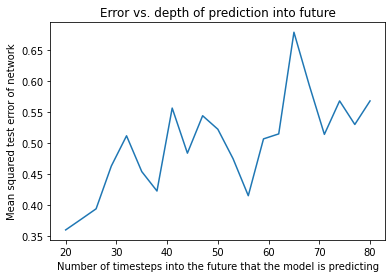

In [46]:
# -- HOW FAR INTO THE FUTURE CAN THE NETWORK PREDICT? -- 

# Making testing data

z0=[np.pi/2,0,np.pi/2,0]
tmax, dt = 100, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2) 

x1=np.reshape(x1,(np.shape(x1)[0],1))
x2=np.reshape(x2,(np.shape(x2)[0],1))
y1=np.reshape(y1,(np.shape(y1)[0],1))
y2=np.reshape(y2,(np.shape(y2)[0],1))

positions=np.concatenate((x1,x2,y1,y2),axis=1)


# Setting training parameters

training_steps=80
num_offsets=21
offsets=np.linspace(20,80,num_offsets) # array containing different depths into the future we want to predict for 

# initialising the mean_squared_test_error array:
mean_squared_test_error=np.zeros(num_offsets)


for j in range(num_offsets):
  
  #Define and compile model
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(64,input_shape=(windowsize,4),return_sequences=True)) # LSTM layer with 64 neurons
  model.add(keras.layers.LSTM(32))
  model.add(keras.layers.Dense(32,activation="linear"))
  model.add(keras.layers.Dense(4,activation="linear"))
  model.compile(loss='mean_squared_error',optimizer='adam')

  # initialising the cost array
  cost=np.zeros(training_steps)  
  
  for i in tqdm(range(training_steps)):
 
    theta_1_start=np.random.uniform(low=((np.pi/2)),high=((np.pi/2)))
    theta_2_start=np.random.uniform(low=((np.pi/2)-0.01),high=((np.pi/2)+0.01))

    z0=[theta_1_start,0,theta_2_start,0]
    tmax, dt = 100, 0.1
    t = np.arange(0, tmax+dt, dt)
    
    # Solve initial value problem
    ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y

    # Extract result
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)   
    
    # Make training data
    x1=np.reshape(x1,(np.shape(x1)[0],1))
    x2=np.reshape(x2,(np.shape(x2)[0],1))
    y1=np.reshape(y1,(np.shape(y1)[0],1))
    y2=np.reshape(y2,(np.shape(y2)[0],1))

    positions=np.concatenate((x1,x2,y1,y2),axis=1)

    # defining the number of timesteps (as required by the shapeArray function, which we will call next)
    timesteps=int(tmax//dt)

    # Making input and output arrays:
    input,output=shapeArray(positions,windowsize,int(offsets[j]))
    output=output[:,-1,:]
    
    # Training
    cost[i]=model.train_on_batch(input,output)
  
  # Making testing input and output arrays:
  timesteps=int(tmax//dt)
  test_input,test_output=shapeArray(positions,windowsize,int(offsets[j]))
  test_output=test_output[:,-1,:]

  # TESTING
  prediction = model.predict_on_batch(test_input)
  mean_squared_test_error[j] = np.mean((prediction-test_output)**2)

#Plot costs vs steps
fig,ax=plt.subplots()
ax.plot(offsets,mean_squared_test_error)
ax.set_xlabel("Number of timesteps into the future that the model is predicting")
ax.set_ylabel("Mean squared test error of network")
ax.set_title("Error vs. depth of prediction into future")

Discussion: it can be seen from the plot that the mean squared test error generally increases with the prediction depth. I think that this is again due to the more chaotic nature of the system with the initial conditions of $z_0=[\pi/2,0,\pi/2,0]$ as compared to the system with initial conditions of $z_0=[\pi/4,0,\pi/4,0]$. The network remains effective at predicting positions deeper into the future for the more predictable system, whereas from the plot above we can see that with this more chaotic system, the prediction performance decreases (since error increases) with prediciton depth. However, even at a prediction depth of 80 timesteps into the future, this second network gets a mean squared testing error of around 0.55, which is still much better than chance (which would result in a mean squared error of 1, ie half the range of the position coordinates). 